In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, GRU, Conv1D, MaxPooling1D, Flatten, Input, concatenate,GlobalMaxPooling1D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

In [3]:
PATH = '/kaggle/input/cb-cleaned/cyberbullying_tweets_cleaned.csv'
data = pd.read_csv(PATH)
data.head()

,tweet_text,cyberbullying_type,cleaned_text,language,length,contains_num,capital_ratio,word_count,avg_word_length,sentence_count,avg_sentence_length,hapax_ratio,ttr,elongated_count
0,"In other words #katandandre, your food was cra...",not_cyberbullying,in other words your food was crapilicious,en,41,0,0.020408,9,4.076923,2,4.5,1.000000,1.000000,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,why is so white,en,15,1,0.134831,14,4.080000,2,7.0,1.000000,1.000000,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,a classy whore or more red velvet cupcakes,en,42,0,0.061224,9,4.333333,2,4.5,1.000000,1.000000,1
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thanks for the heads up but not too conc...,en,87,0,0.037975,18,3.695652,2,9.0,1.000000,1.000000,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,this is an isis account pretending to be a kur...,en,84,0,0.123457,18,3.863636,2,9.0,0.777778,0.888889,0


In [4]:
LABEL = 'cyberbullying_type'

In [5]:
X = data.drop(columns=[LABEL])
y = data[LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_text = X_train['cleaned_text'].values
X_test_text = X_test['cleaned_text'].values
X_train_num = X_train.drop(columns=['cleaned_text', 'tweet_text', 'language'])
X_test_num = X_test.drop(columns=['cleaned_text', 'tweet_text', 'language'])

In [7]:
sentence_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

# encode
X_train_embeddings = sentence_model.encode(X_train_text, show_progress_bar=True)
X_test_embeddings = sentence_model.encode(X_test_text, show_progress_bar=True)



modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1183 [00:00<?, ?it/s]

Batches:   0%|          | 0/296 [00:00<?, ?it/s]

In [9]:
np.save('X_train_embeddings.npy', X_train_embeddings)
np.save('X_test_embeddings.npy', X_test_embeddings)

In [17]:
X_train_embeddings.shape

(37852, 768)

In [19]:
# load text embeddings
X_train_embeddings = np.load('/kaggle/input/cb-emb/X_train_embeddings.npy')
X_test_embeddings = np.load('/kaggle/input/cb-emb/X_test_embeddings.npy')

In [20]:
X_train_embeddings.shape

(37852, 768)

In [21]:
X_train_final = np.hstack((X_train_embeddings, X_train_num.values))
X_test_final = np.hstack((X_test_embeddings, X_test_num.values))
X_train_final.shape, X_test_final.shape

((37852, 778), (9464, 778))

In [11]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

## Baseline Model

Model: Random Forest
F1 Score: 0.7695
                     precision    recall  f1-score   support

                age       0.91      0.96      0.94      1599
          ethnicity       0.94      0.92      0.93      1590
             gender       0.85      0.79      0.82      1582
  not_cyberbullying       0.50      0.49      0.50      1563
other_cyberbullying       0.49      0.49      0.49      1530
           religion       0.91      0.95      0.93      1600

           accuracy                           0.77      9464
          macro avg       0.77      0.77      0.77      9464
       weighted avg       0.77      0.77      0.77      9464



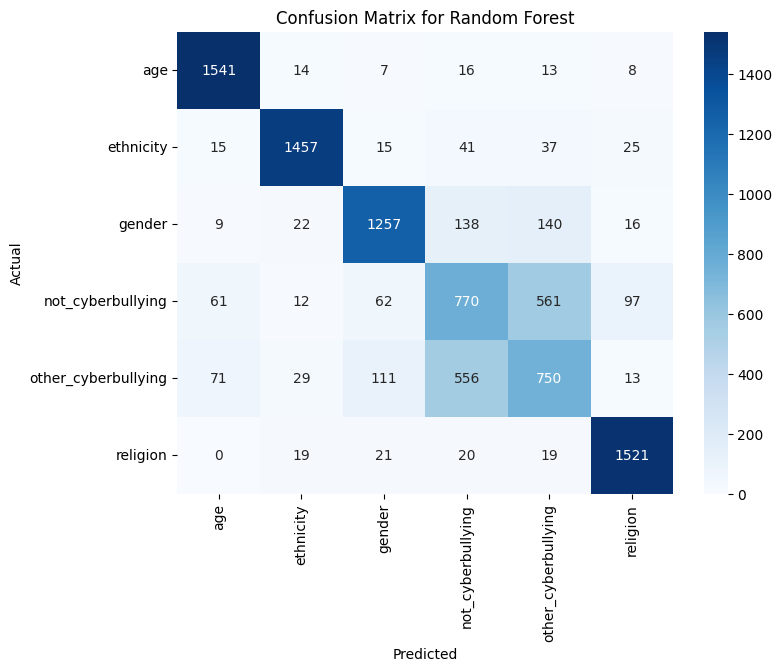

Model: CatBoost
F1 Score: 0.8061
                     precision    recall  f1-score   support

                age       0.95      0.97      0.96      1599
          ethnicity       0.96      0.94      0.95      1590
             gender       0.86      0.84      0.85      1582
  not_cyberbullying       0.56      0.54      0.55      1563
other_cyberbullying       0.56      0.58      0.57      1530
           religion       0.93      0.96      0.94      1600

           accuracy                           0.81      9464
          macro avg       0.80      0.80      0.80      9464
       weighted avg       0.81      0.81      0.81      9464



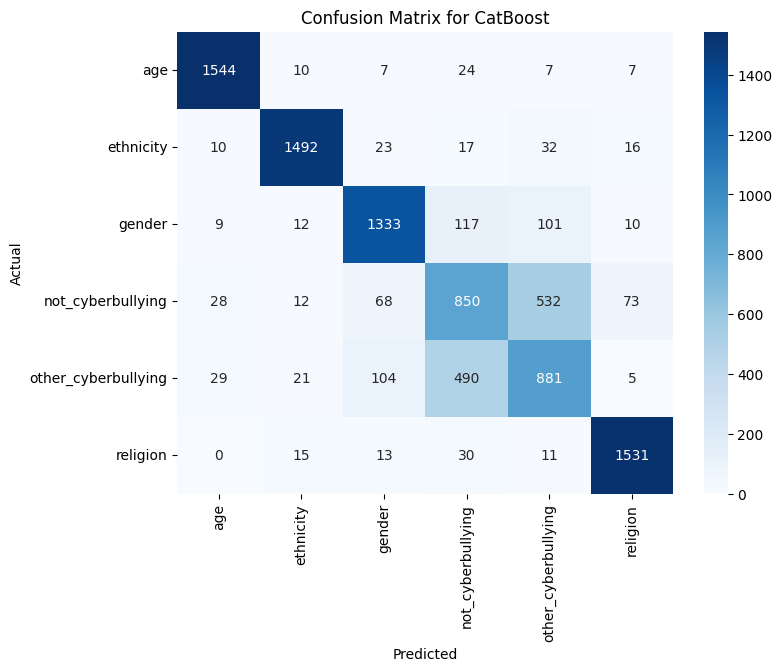

Model: XGBoost
F1 Score: 0.7999
                     precision    recall  f1-score   support

                age       0.96      0.96      0.96      1599
          ethnicity       0.96      0.93      0.95      1590
             gender       0.86      0.82      0.84      1582
  not_cyberbullying       0.53      0.52      0.53      1563
other_cyberbullying       0.54      0.58      0.56      1530
           religion       0.94      0.95      0.94      1600

           accuracy                           0.80      9464
          macro avg       0.80      0.80      0.80      9464
       weighted avg       0.80      0.80      0.80      9464



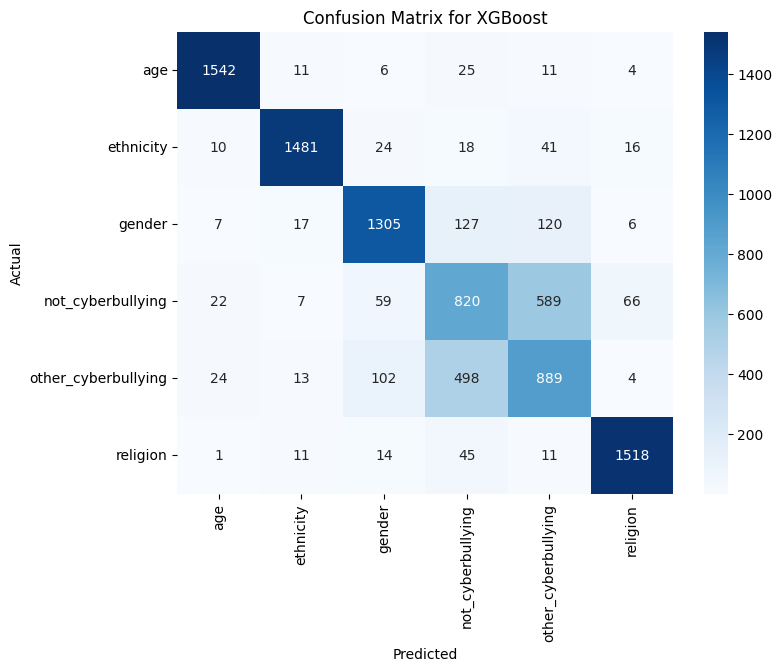

Model: LightGBM


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


F1 Score: 0.8036
                     precision    recall  f1-score   support

                age       0.96      0.97      0.96      1599
          ethnicity       0.96      0.93      0.95      1590
             gender       0.86      0.84      0.85      1582
  not_cyberbullying       0.54      0.53      0.53      1563
other_cyberbullying       0.55      0.58      0.57      1530
           religion       0.94      0.95      0.94      1600

           accuracy                           0.80      9464
          macro avg       0.80      0.80      0.80      9464
       weighted avg       0.80      0.80      0.80      9464



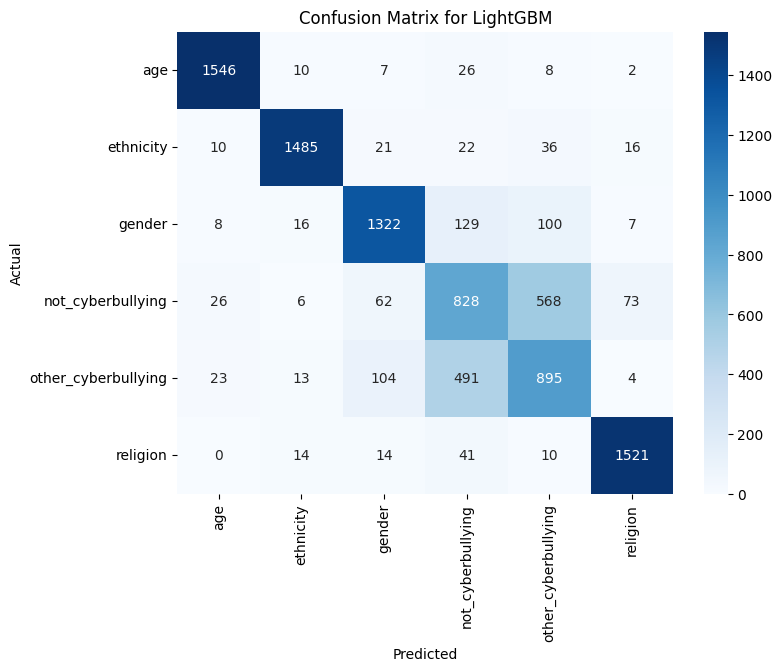

Model: SVM
F1 Score: 0.5352
                     precision    recall  f1-score   support

                age       0.70      0.64      0.67      1599
          ethnicity       0.96      0.52      0.68      1590
             gender       0.48      0.44      0.46      1582
  not_cyberbullying       0.31      0.64      0.42      1563
other_cyberbullying       0.45      0.26      0.33      1530
           religion       0.66      0.64      0.65      1600

           accuracy                           0.53      9464
          macro avg       0.59      0.52      0.53      9464
       weighted avg       0.59      0.53      0.54      9464



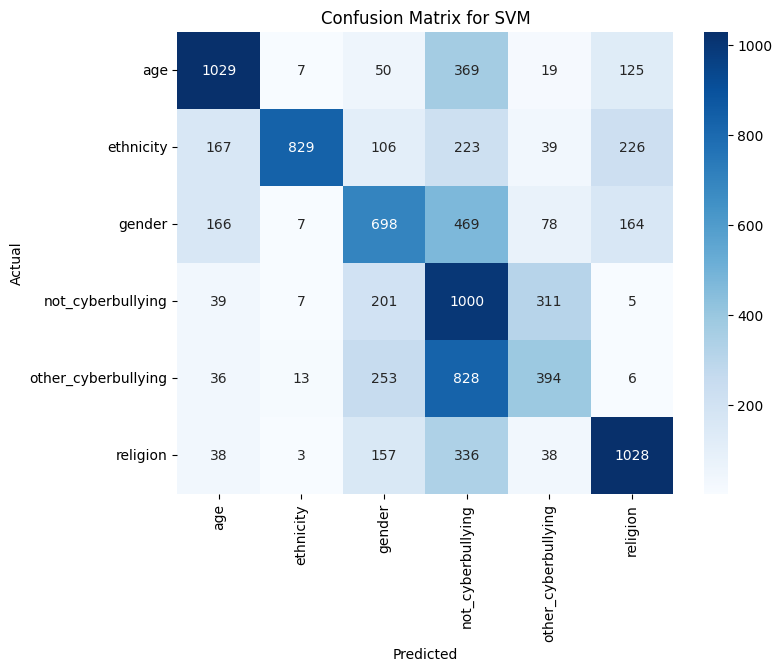

In [23]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0, task_type="GPU"),
    'XGBoost': XGBClassifier(random_state=42, tree_method='gpu_hist', predictor='gpu_predictor'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1, device='gpu'),
    'SVM': SVC()
}

def modelling(X_train, y_train, X_test, y_test, models):
    name_l, f1_scores = [], []
    for name, model in models.items():
        print(f"Model: {name}")
        name_l.append(name)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"F1 Score: {f1:.4f}")
        f1_scores.append(f1)
        print(classification_report(y_test, y_pred, target_names=encoder.classes_))
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    return pd.DataFrame({'Model': name_l, 'F1 Score': f1_scores})

results = modelling(X_train_final, y_train_encoded, X_test_final, y_test_encoded, models)
results.sort_values(by='F1 Score', ascending=False, inplace=True)
        

In [6]:
X_train_text = X_train_text.astype(str).tolist()
X_test_text = X_test_text.astype(str).tolist()

In [ ]:
MODEL_NAME = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

def encode_texts(text_list):
    inputs = tokenizer(
        text_list,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(**inputs)

    # Token embeddings: (batch, seq_len, 768)
    return outputs.last_hidden_state

X_train_tokens = encode_texts(X_train_text)
X_test_tokens = encode_texts(X_test_text)


tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

## Transformer based Model (bert-base-multilingual-cased)

In [6]:

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Using device: cuda
Train size: 37852
Test size: 9464
Numeric feature size: 10
Number of classes: 6
Starting training for 3 epochs...

Epoch 1/3


Validation: 100%|██████████| 592/592 [01:27<00:00,  6.75it/s]


Train Loss: 0.7097
Val Loss: 0.4521 | Val Acc: 0.8196 | Val F1: 0.8147
Best model saved with accuracy: 0.8196

Epoch 2/3


Validation: 100%|██████████| 592/592 [01:27<00:00,  6.78it/s] loss=0.292]  


Train Loss: 0.4015
Val Loss: 0.4133 | Val Acc: 0.8402 | Val F1: 0.8370
Best model saved with accuracy: 0.8402

Epoch 3/3


Validation: 100%|██████████| 592/592 [01:27<00:00,  6.76it/s]


Train Loss: 0.3224
Val Loss: 0.4143 | Val Acc: 0.8409 | Val F1: 0.8397
Best model saved with accuracy: 0.8409

Training completed!

EVALUATION ON TEST SET


Predicting: 100%|██████████| 592/592 [01:27<00:00,  6.73it/s]



Weighted F1 Score: 0.8397

Classification Report:
                     precision    recall  f1-score   support

                age       0.98      0.98      0.98      1599
          ethnicity       0.99      0.98      0.98      1590
             gender       0.88      0.88      0.88      1582
  not_cyberbullying       0.63      0.52      0.57      1563
other_cyberbullying       0.61      0.72      0.66      1530
           religion       0.95      0.96      0.96      1600

           accuracy                           0.84      9464
          macro avg       0.84      0.84      0.84      9464
       weighted avg       0.84      0.84      0.84      9464



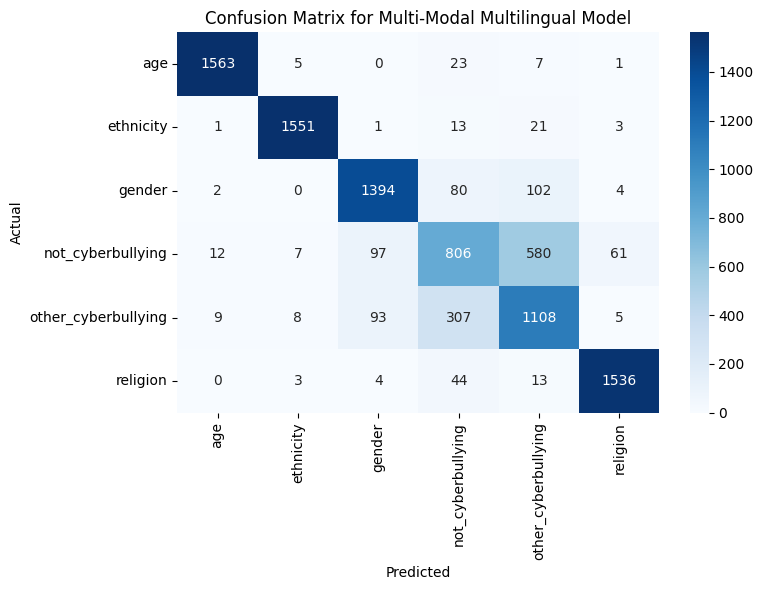


Model evaluation completed!


In [ ]:
class MultiModalDataset(Dataset):
    def __init__(self, texts, numeric_features, labels, tokenizer, max_length=128):
        self.texts = list(texts) if not isinstance(texts, list) else texts
        self.numeric_features = np.array(numeric_features)
        self.labels = list(labels) if not isinstance(labels, list) else labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        numeric = self.numeric_features[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'numeric_features': torch.tensor(numeric, dtype=torch.float32),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class MultiModalBERT(nn.Module):
    def __init__(self, bert_model_name, num_classes, numeric_feature_size, dropout=0.3):
        super(MultiModalBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)

        self.text_dropout = nn.Dropout(dropout)

        self.numeric_fc = nn.Sequential(
            nn.Linear(numeric_feature_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        combined_size = self.bert.config.hidden_size + 64
        self.classifier = nn.Sequential(
            nn.Linear(combined_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, input_ids, attention_mask, numeric_features):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_dropout(outputs.pooler_output)
        
        numeric_encoded = self.numeric_fc(numeric_features)
        
        combined = torch.cat([text_features, numeric_encoded], dim=1)
        
        logits = self.classifier(combined)
        return logits

class MultiModalTrainer:
    def __init__(self, model, train_loader, val_loader, device, lr=2e-5, epochs=3):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.epochs = epochs
        
        self.optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
        total_steps = len(train_loader) * epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )
        self.criterion = nn.CrossEntropyLoss()
        
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
    
    def train_epoch(self):
        self.model.train()
        total_loss = 0
        progress_bar = tqdm(self.train_loader, desc='Training')
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            numeric_features = batch['numeric_features'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            self.optimizer.zero_grad()
            logits = self.model(input_ids, attention_mask, numeric_features)
            loss = self.criterion(logits, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()
            
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        return total_loss / len(self.train_loader)
    
    def validate(self):
        self.model.eval()
        total_loss = 0
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc='Validation'):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                numeric_features = batch['numeric_features'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                logits = self.model(input_ids, attention_mask, numeric_features)
                loss = self.criterion(logits, labels)
                total_loss += loss.item()
                
                preds = torch.argmax(logits, dim=1)
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        avg_loss = total_loss / len(self.val_loader)
        accuracy = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions, average='weighted')
        
        return avg_loss, accuracy, f1, predictions, true_labels
    
    def predict(self, test_loader):
        self.model.eval()
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for batch in tqdm(test_loader, desc='Predicting'):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                numeric_features = batch['numeric_features'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                logits = self.model(input_ids, attention_mask, numeric_features)
                preds = torch.argmax(logits, dim=1)
                
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        return np.array(predictions), np.array(true_labels)
    
    def train(self):
        print(f"Starting training for {self.epochs} epochs...")
        best_accuracy = 0
        
        for epoch in range(self.epochs):
            print(f"\nEpoch {epoch + 1}/{self.epochs}")
            
            train_loss = self.train_epoch()
            val_loss, val_acc, val_f1, preds, labels = self.validate()
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
            
            # Save best model
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                torch.save(self.model.state_dict(), 'best_multimodal_multilingual_bert.pt')
                print(f"Best model saved with accuracy: {best_accuracy:.4f}")
        
        print("\nTraining completed!")
        return self.train_losses, self.val_losses, self.val_accuracies

BERT_MODEL = "bert-base-multilingual-cased"
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

print(f"Train size: {len(X_train_text)}")
print(f"Test size: {len(X_test_text)}")
print(f"Numeric feature size: {X_train_num.shape[1]}")
print(f"Number of classes: {len(encoder.classes_)}")

train_dataset = MultiModalDataset(X_train_text, X_train_num, y_train_encoded, tokenizer, MAX_LENGTH)
test_dataset = MultiModalDataset(X_test_text, X_test_num, y_test_encoded, tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model = MultiModalBERT(
    bert_model_name=BERT_MODEL,
    num_classes=len(encoder.classes_),
    numeric_feature_size=X_train_num.shape[1]
)

trainer = MultiModalTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    device=device,
    lr=LEARNING_RATE,
    epochs=EPOCHS
)

train_losses, val_losses, val_accuracies = trainer.train()

model.load_state_dict(torch.load('best_multimodal_multilingual_bert.pt'))
print("\n" + "="*60)
print("EVALUATION ON TEST SET")
print("="*60)

y_pred_classes, y_test_encoded = trainer.predict(test_loader)
print(f'\nWeighted F1 Score: {f1_score(y_test_encoded, y_pred_classes, average="weighted"):.4f}')
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_classes, target_names=encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, 
            yticklabels=encoder.classes_)
plt.title('Confusion Matrix for Multi-Modal Multilingual Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("\nModel evaluation completed!")